In [1]:
# 1. 표준/외부 라이브러리 임포트
import functools
import operator
from datetime import datetime
from typing import Sequence, Annotated, Literal, Optional, Dict, List, Any
from typing_extensions import TypedDict
import uuid
import asyncio
import sys
import json

In [2]:
from dotenv import load_dotenv
from langchain.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, load_prompt
from langchain_core.runnables import RunnableConfig
from langchain_core.tools.retriever import create_retriever_tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import stream_graph, random_uuid, invoke_graph
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel

In [3]:
# 2. 환경 변수 및 상수
load_dotenv()
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
now

'2025-07-26 00:15:33'

In [4]:
# 3. 로컬 모듈 임포트
from manse_8 import calculate_saju_tool
from pdf_retriever_saju import pdf_rag_chain, compression_retriever
from query_expansion_agent import get_query_expansion_node, get_query_expansion_agent

In [5]:
# 4. 데이터 구조 정의
class BirthInfo(TypedDict):
    year: int
    month: int
    day: int
    hour: int
    minute: int
    is_male: bool
    is_leap_month: bool

In [6]:
class SajuResult(TypedDict):
    year_pillar: str
    month_pillar: str
    day_pillar: str
    hour_pillar: str
    day_master: str
    age: int
    korean_age: int
    element_strength: Optional[Dict[str, int]]
    ten_gods: Optional[Dict[str, List[str]]]
    great_fortunes: Optional[List[Dict[str, Any]]]
    yearly_fortunes: Optional[List[Dict[str, Any]]]
    useful_gods: Optional[List[str]]
    taboo_gods: Optional[List[str]]
    saju_analysis: Optional[str]

In [7]:
class AgentState(TypedDict):
    question: str
    messages: Annotated[List[BaseMessage], operator.add]
    next: str
    final_answer: Optional[str]
    session_id: str
    session_start_time: str
    current_time: str
    birth_info: Optional[BirthInfo]
    saju_result: Optional[SajuResult]
    query_type: str
    retrieved_docs: List[Dict[str, Any]]
    web_search_results: List[Dict[str, Any]]

In [8]:
# 5. 도구 및 에이전트 생성
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
pdf_retriever = compression_retriever()
pdf_chain = pdf_rag_chain()
retriever_tool = create_retriever_tool(
    pdf_retriever,
    "pdf_retriever",
    "A tool for searching information related to Saju (Four Pillars of Destiny)",
    document_prompt=PromptTemplate.from_template(
        "<document><context>{page_content}</context><metadata><source>{source}</source></metadata></document>"
    ),
)

In [9]:
# manse tool
manse_tools = [calculate_saju_tool]
manse_tool_prompt = """
사주(四柱) 계산 결과를 바탕으로, 사용자에게 친절하고 이해하기 쉬운 자연어로 사주풀이 결과를 설명해 주세요.
답변은 다음의 **항목을 모두 포함**하거나, 사용자가 특정 항목만 질문한 경우에는 해당 항목을 중심적으로 구체적으로 안내해 주세요.
사주 계산 결과를 바탕으로, 사용자에게 친절하고 이해하기 쉬운 자연어로 사주풀이 결과를 설명해 주세요.

**답변 맨 앞에, 아래와 같이 ‘사주 전체 요약’(3~5줄)을 먼저 제시해 주세요.**
- 사주 전반의 흐름, 가장 큰 특징, 기운의 방향성, 전체적인 조언 등을 종합적으로 안내해 주세요.
- 중요한 변화 시기, 주목할 만한 운, 가장 강한/부족한 에너지 등도 요약에 포함해 주세요.

이후 다음의 항목을 모두 포함하거나, 사용자가 특정 항목만 질문한 경우 해당 항목만 집중적으로 안내해 주세요.

1. 십신 분석 (비견, 겁재, 식신, 상관, 편재, 정재, 편관, 정관, 편인, 정인 등)
2. 오행 분석 (목, 화, 토, 금, 수)
3. 오행 보완법 (실생활에서 적용할 구체적 방법)
4. 대운
5. 세운
6. 건강운
7. 재물운
8. 금전운
9. 직업운
10. 성공운
11. 애정운 (연애, 결혼, 인연, 대인관계)
12. 학업운/시험운
13. 가족운/자녀운
14. 이동운/변화운
15. 사회운/인복/대인관계
16. 사업운/창업운
17. 명예운/승진운
18. 기타 특수운(필요 시: 소송, 법률, 여행, 복권, 투자 등)

**답변 마지막에는, 전체 내용을 간단히 정리하거나 종합적 조언(1~3줄)과 마무리 멘트(“더 궁금하신 점이 있으시면 언제든 질문해 주세요.” 등)를 꼭 넣어주세요.**

- 각 항목은 반드시 구체적인 근거(오행, 십신, 용신, 기운의 균형 등)를 들어 설명하고, 조언을 담은 존댓말로 전달해 주세요.
- **긍정적이고 조언을 담은 존댓말**로 전달해 주세요. 하지만 주의할점이 있다면 그 내용또한 전달해 주세요.
- 예언이나 단정적인 표현 대신, 경향·조언·주의점 중심으로 안내해 주세요.
- 불안감을 줄 수 있는 부정적 표현("불행하다", "위험하다", "나쁘다" 등)은 사용하지 마세요.
- 항목별로 비슷한 문장이 반복되지 않도록 주의하고, 각 항목마다 어휘와 문장 구조를 다양하게 사용해 주세요.

---

**[예시]**

**사주 전체 요약**  
올해는 새로운 기운이 강하게 들어오는 시기입니다. 대인관계와 직업적 기회가 풍부하며, 금전과 애정운도 전반적으로 긍정적인 흐름을 보입니다. 다만, 건강과 감정 관리에는 꾸준한 관심이 필요합니다.

**십신 분석**  
겁재(2개): 경쟁심이 강하며, 대인관계에서 주도적입니다. 가끔은 융통성이 필요할 수 있습니다.  
정관(1개): 책임감이 있고 규칙을 중시하지만, 때로는 융통성을 보완하면 더 좋습니다.

**오행 분석**  
목(木)이 강하고 수(水)가 부족합니다. 목이 강해 추진력과 성장성이 뛰어나지만, 감정 조절이나 유연함이 부족할 수 있습니다.

**오행 보완법**  
수(水)가 부족하다면 파란색 계열 옷, 물과 관련된 활동(수영, 산책), 해조류·생선 등 수의 기운을 돋우는 음식을 추천합니다.

**대운**  
2025~2034년(38~47세) 대운에는 식신과 편관의 기운이 두드러집니다.  
이 시기에는 새로운 프로젝트나 사업을 시작하면 성과를 내기 쉽고, 직장에서 중요한 역할을 맡게 될 가능성이 높습니다.  
다만, 이 시기에는 경쟁이 심해질 수 있으니, 감정 조절과 꾸준한 자기계발이 중요합니다.

2035~2044년(48~57세) 대운에는 재물운과 인복이 강해집니다.  
금전적 기회가 많아지는 한편, 가족·친구와의 관계도 깊어질 수 있습니다.  
그러나 투자와 소비의 균형에 신경 써야 안정적인 성과를 유지할 수 있습니다.

**세운**  
2024년: 정관이 강해져서 직장 내 평가나 승진 운이 들어옵니다.  
새로운 업무 기회를 잘 활용하면 성장의 발판이 마련될 수 있습니다.

2025년: 재물운이 상승하여 뜻밖의 수입이나 투자 기회가 생길 수 있습니다.  
하지만 무리한 지출이나 충동구매에는 주의해야 합니다.

2026년: 건강운이 약간 약해질 수 있어 꾸준한 운동과 규칙적인 생활습관이 필요합니다.  
특히 소화기·순환기 관리에 신경을 쓰면 도움이 됩니다.

**애정운**  
올해는 새로운 인연이 생기기 쉬운 시기입니다. 열린 마음으로 주변 사람들과 소통하면 좋은 결과가 있을 것입니다.

**종합 해석**  
전반적으로 긍정적 변화가 기대되는 시기이며, 적극적으로 도전하신다면 좋은 결과를 얻을 수 있습니다. 궁금하신 점이 있으시면 언제든 질문해 주세요.

...

---
"""



llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
manse_tool_agent = create_react_agent(llm, manse_tools, prompt=manse_tool_prompt).with_config({"tags": ["final_answer_agent"]})

In [10]:
# retriever tool
retriever_tools = [retriever_tool]
base_prompt = load_prompt("prompt/saju-rag-promt_2.yaml")
saju_prompt = ChatPromptTemplate.from_messages([
    ("system", f"Today is {now}, 사주에 대해서 자세한 설명이 필요하면 retriever를 사용해 답합니다."),
    ("system", base_prompt.template),
    MessagesPlaceholder("messages"),
])
retriever_tool_agent = create_react_agent(llm, retriever_tools, prompt=saju_prompt).with_config({"tags": ["final_answer_agent"]})

In [11]:
# web search tool
tavily_tool = TavilySearch(max_results=2, include_domains=["namu.wiki", "wikipedia.org"])
duck_tool = DuckDuckGoSearchResults(max_results=2)
web_search_tools = [tavily_tool, duck_tool]
web_search_prompt = "십신분석의 개념, 사주개념, 또는 사주 오행의 개념적 질문이 들어오면, web search를 통해 답합니다."
web_tool_agent = create_react_agent(llm, tools=web_search_tools, prompt=web_search_prompt).with_config({"tags": ["final_answer_agent"]})

In [12]:
@tool
def general_qa_tool(query: str) -> str:
    """
    일반적인 질문이나 상식적인 내용에 대해 답변합니다. 사주와 관련 없는 모든 질문에 사용할 수 있습니다.
    """
    google_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
    return google_llm.invoke(query)

general_qa_tools = [general_qa_tool]
general_qa_prompt = """
아래는 사용자가 일반적인 질문을 한 경우입니다.  

사주 정보(birth_info, saju_result 등)가 포함되어 있다면,  
답변에 자연스럽게 그 정보를 녹여서,  
**'실제 대화하듯, 친근하고 진심 어린 존댓말'로 상담해 주세요.**

- 답변은 핵심만 간결하게, 한 번에 3~5문장 이내(너무 길지 않게)로 해주세요.
- 만약 질문이 사주와 무관하다면, 일반적인 정보/상식/지식 답변을 먼저 드리고,
- 답변 마지막에 "참고로, 사주 정보에 따르면 ~~~도 도움/영향이 될 수 있습니다."처럼 
  사주와 연결될 수 있는 조언이 있으면 추가해 주세요.
- 혹은 "추가로 궁금하신 점 있으시면 언제든 물어봐 주세요!" 등 친근한 마무리 멘트도 넣어주세요.
- 사주 정보가 없는 경우엔, 일반 QA 스타일의 답변을 제공해 주세요.

아래는 예시입니다.

---
Q: 다이어트에 좋은 음식이 뭔가요?
A:  
다이어트에는 단백질이 풍부한 음식(닭가슴살, 두부, 생선), 신선한 채소, 견과류, 충분한 수분 섭취가 도움이 됩니다.  
참고로, 사주에서 토(土) 기운이 약하신 경우, 고구마나 콩류, 노란색·갈색 음식이 몸의 균형에 더 도움이 될 수 있습니다.  
추가로 궁금한 점 있으시면 언제든 질문해 주세요!
---
Q: 오늘 날씨 어때요?
A:  
오늘은 전국적으로 맑고 기온이 따뜻하겠습니다.  
만약 외출 계획이 있으시다면, 사주에서 수(水) 기운이 약할 때는 충분한 수분 섭취와 휴식도 함께 챙겨보시는 걸 추천드립니다.

---
"""

general_qa_agent = create_react_agent(llm, tools=general_qa_tools, prompt=general_qa_prompt).with_config({"tags": ["final_answer_agent"]})
query_expansion_node = get_query_expansion_node()

In [13]:
# 6. 핵심 함수(노드, 파싱, 라우팅 등)
def agent_node(state, agent, name):
    agent_response = agent.invoke(state)
    state["messages"] = state.get("messages", []) + [HumanMessage(content=agent_response["messages"][-1].content, name=name)]
    return state

def parse_birth_info_with_llm(user_input, llm):
    prompt = f"""
    아래 문장에서 출생 정보를 추출해서 JSON 형태로 반환하세요.
    필드: year, month, day, hour, minute, is_male, is_leap_month
    예시 입력: "1996년 12월 13일 남자, 10시 30분 출생"
    예시 출력: {{"year": 1996, "month": 12, "day": 13, "hour": 10, "minute": 30, "is_male": true, "is_leap_month": false}}

    입력: {user_input}
    """
    result = llm.invoke(prompt)
    try:
        birth_info = json.loads(result.content)
        return birth_info
    except Exception as e:
        print("파싱 오류:", e)
        return None

def manse_agent_node(state):
    user_input = state["question"]
    birth_info = parse_birth_info_with_llm(user_input, llm)
    state["birth_info"] = birth_info
    saju_result = calculate_saju_tool(birth_info)
    state["saju_result"] = saju_result
    prompt = f"""
    아래는 사용자의 사주 정보와 계산 결과입니다.
    - 입력: {user_input}
    - 사주 계산 결과: {json.dumps(saju_result, ensure_ascii=False, indent=2)}
    위 정보를 바탕으로, 사용자가 이해하기 쉽게 사주풀이 결과를 자연어로 설명해 주세요.
    """
    llm_response = llm.invoke(prompt)
    state["messages"].append(HumanMessage(content=llm_response.content, name="ManseLLM"))
    return state

manse_tool_agent_node = functools.partial(agent_node, agent=manse_tool_agent, name="ManseTool")
retriever_tool_agent_node = functools.partial(agent_node, agent=retriever_tool_agent, name="RetrieverTool")
web_tool_agent_node = functools.partial(agent_node, agent=web_tool_agent, name="WebTool")
general_qa_agent_node = functools.partial(agent_node, agent=general_qa_agent, name="GeneralQA")

In [14]:
def classify_search_llm(user_input, llm):
    prompt = """
    - 'retriever': 사주에 대한 자세한 설명이 필요하면 retriever(retriever_tool_agent_node)
    - 'web': 특별한 내부 언급이 없거나, 일반적/공개 정보/공식/인터넷/최신/정의/설명/이론/근거/출처 등은 web(web_tool_agent_node)
    - 'web': 십신분석의 개념, 사주개념, 또는 사주 오행의 개념적 질문이 들어오면, web(web_tool_agent_node)
    둘 중 가장 적합한 카테고리( retriever / web )만 답변하세요.
    

    질문: "{user_input}"
    정답:
    """.format(user_input=user_input)
    result = llm.invoke(prompt)
    
    return result.content.strip().lower()

def search_agent_node(state):
    user_input = state.get("question") or (state["messages"][0].content if state.get("messages") else "")
    category = classify_search_llm(user_input, llm)
    if category == "retriever":
        return retriever_tool_agent_node(state)
    else:
        return web_tool_agent_node(state)

In [15]:
members = ["search", "manse", "general_qa"]
options_for_next = ["FINISH"] + members

In [16]:
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]


In [33]:
supervisor_system_prompt = (
    f"오늘 날짜는 {now}입니다.\n"
    "당신은 다음과 같은 전문 에이전트들을 조율하는 Supervisor입니다: {members}.\n"
    "입력(사용자 질문)에 따라 가장 적합한 에이전트로 한 번만 분기하세요. "
    "이미 답변을 생성한 에이전트/질문으로 반복 분기하지 마세요. 무한루프에 빠지지 않도록 주의하세요.\n\n"
    "이미 해당 질문에 대해 답변한 에이전트로는 다시 분기하지 마세요. 동일한 질문/의도가 반복될 때는 반드시 FINISH로 이동하세요."
    "이전에 보냈던 노드로 연속해서 보내지 마세요."

    "각 에이전트의 역할은 다음과 같습니다:\n"
    "- search: 용어/개념/정의/이론/분류/설명/공식/자료/논문/출처 등, 예를 들어 '불속성이 뭐야?', '오행 각각의 의미', '정관 정의', '십신 종류', '사주에서 겁재는?', '오행 설명' 등 정보성 질문에서만 사용하세요. 운세 풀이/미래/해석/내 운세/금전운/재물운 등 해석이나 미래 흐름을 묻는 질문은 절대 search로 보내지 마세요.\n"
    "사용자가 '겁재', '정관', '오행', '십신', '명리', '사주 용어', '이론', '공식 정의', '개념', '분류', '근거', '출처', '자료', '논문', '문서', 'DB', 'pdf', '설명', '분석' 등 '개념', '정의', '이론', '용어 설명'을 묻거나 자료/출처/공식 설명을 요구할 때만 사용하세요. search는 반드시 용어/개념/정의/분류/이론/공식/자료/논문 등 정보성 질문에서만 사용해야 하며, 운세 풀이(사주해석)는 절대 하지 않습니다.\n"
    "사주에 대해서 자세한 설명이 필요하면 retriever를 사용해 답합니다.\n"
    "십신분석의 개념, 사주개념, 또는 사주 오행의 개념적 질문이 들어오면, web를 사용해 답합니다..\n"
    "search 노드는 답변만 생성하며, 일반적인 고민/일상/잡담/추천/선택/음식 등에는 절대 사용하지 않습니다.\n"

    "- manse: 생년월일/시간을 입력받았을 때, 사주풀이, 운세 해석, 상세 분석 담당. "
    "생년월일/시간/성별/운세 관련 정보가 있을 때만 사용."
    "사주의 개념적질문, 일상 메뉴, 잡담, 선택, 고민 등은 manse로 보내지 않습니다..n"    
    "'겁재가 뭐야?', '오행 설명해줘', '십신의 의미' 등 용어/개념/정의/설명/이론 질문은 절대 manse에서 처리하지 마세요.\n"

    "- general_qa: 일반 상식, 생활 정보, 건강, 공부, 영어, 주식, 투자, 프로그래밍, 고민 상담, **일상 잡담**, **일반적인 질문**이나 '대화형 질문', **음식**, 선택, 추천, 오늘 할 일, 무엇을 고를지, 등등은 모두 general_qa 담당**\n"
    "일반/일상/잡담/선택형 질문에 대해 이미 gen eral_qa가 답변을 생성했다면,"
    "만약 general_qa에서 답변이 이미 생성된 경우에는 state에 birth_info, saju_result가 있어도 다시 manse로 보내지 말고 반드시 FINISH(종료)로 넘기세요."

    "예시)\n"
    "Q: '겁재가 뭐야?' '오행이 뭔가요?' '정관 정의 알려줘.', '화속성이 뭐야?' '수기운 설명해줘' → search\n"
    "Q: '1995년생 남자, 3월 5일 오후 3시' '내 대운에 대해서 알려줘', '내 금전운에 대해서 자세히 알려줘' → manse\n"
    "Q: '오늘 뭐 먹지?', '기분전환 메뉴 추천', '공부법 알려줘',', '영어회화 공부법',  → general_qa\n"
)

supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
              """위 대화를 참고하여, 다음 중 누가 다음 행동을 해야 하는지 선택하세요: {options}
              - 연속해서 같은분기로 분기하지 마세요.
              - 한 분기를 갔으면, Manse로 넘기지 마세요.
              """
              ),
    ]
)

In [40]:
def supervisor_agent(state):
    supervisor_chain = (
        supervisor_prompt.partial(options=str(options_for_next), members=", ".join(members), now=now)
        | llm.with_structured_output(RouteResponse)
    )
    route_response = supervisor_chain.invoke(state)
    return {"next": route_response.next}

In [41]:
# 7. LangGraph 워크플로우 생성
def create_workflow_graph():
    workflow = StateGraph(AgentState)
    workflow.add_node("search", search_agent_node)
    workflow.add_node("manse", manse_tool_agent_node)
    workflow.add_node("general_qa", general_qa_agent_node)
    workflow.add_node("supervisor", supervisor_agent)
    
    # 각 노드에서 직접 END로 이동 (finish)
    workflow.add_edge("search", END)
    workflow.add_edge("manse", END)
    workflow.add_edge("general_qa", END)
    
    # supervisor에서 분기 결정
    conditional_map = {k: k for k in members}
    def get_next(state):
        return state["next"]
    workflow.add_conditional_edges("supervisor", get_next, conditional_map)
    
    # 시작점에서 supervisor로
    workflow.add_edge(START, "supervisor")
    
    return workflow.compile(checkpointer=MemorySaver())

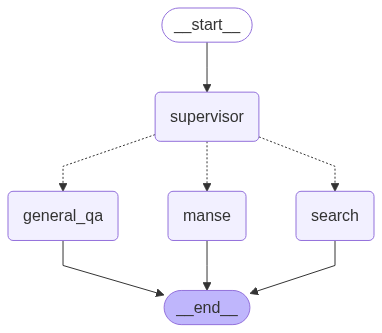

In [42]:
create_workflow_graph()

In [43]:
def run_saju_analysis(messages, thread_id=None, use_stream=True):
    graph = create_workflow_graph()
    if not graph:
        return "그래프 생성에 실패했습니다."
    if thread_id is None:
        thread_id = random_uuid()
    config = RunnableConfig(recursion_limit=20, configurable={"thread_id": thread_id})
    inputs = {"messages": messages}
    if use_stream:
        return stream_graph(graph, inputs, config)
    else:
        return invoke_graph(graph, inputs, config)


In [44]:
# 8. 실행(main) 함수
def main():
    print("사주 에이전틱 RAG 시스템 (병렬 구조 버전)을 시작합니다... ")
    print("생년월일, 태이난 시각, 성별을 입력해 주세요.")
    print("윤달에 태어나신 경우, 윤달이라고 작성해주세요.")
    example_questions = [
        "1996년 12월 13일 남자, 10시 30분 출생 운세봐줘.",
        "대운과 세운, 조심해야 할것들 알려줘",
        "금전운알려줘",
        "정관이 뭐야? 상세히 설명해줘",
        "사주의 개념에 대해서 알려줘"
    ]
    print("\n사용 가능한 예시 질문:")
    for i, question in enumerate(example_questions, 1):
        print(f"{i}. {question}")
    print("\n질문을 입력하세요 (종료하려면 'quit' 입력):")
    chat_history = []
    thread_id = random_uuid()
    while True:
        user_input = input("\n질문: ").strip()
        if user_input.lower() in ['quit', 'exit', '종료']:
            print("시스템을 종료합니다.")
            break
        if not user_input:
            continue
        chat_history.append(HumanMessage(content=user_input))
        try:
            print("\n분석을 시작합니다...")
            result = run_saju_analysis(chat_history, thread_id=thread_id, use_stream=True)
            print("\n분석 완료!")
            if hasattr(result, '__iter__') and not isinstance(result, str):
                last_ai_msg = None
                for msg in result:
                    if hasattr(msg, 'content'):
                        last_ai_msg = msg
                if last_ai_msg:
                    chat_history.append(AIMessage(content=last_ai_msg.content))
        except Exception as e:
            print(f"오류가 발생했습니다: {e}")

if __name__ == "__main__":
    main() 



사주 에이전틱 RAG 시스템 (병렬 구조 버전)을 시작합니다... 
생년월일, 태이난 시각, 성별을 입력해 주세요.
윤달에 태어나신 경우, 윤달이라고 작성해주세요.

사용 가능한 예시 질문:
1. 1996년 12월 13일 남자, 10시 30분 출생 운세봐줘.
2. 대운과 세운, 조심해야 할것들 알려줘
3. 금전운알려줘
4. 정관이 뭐야? 상세히 설명해줘
5. 사주의 개념에 대해서 알려줘

질문을 입력하세요 (종료하려면 'quit' 입력):
시스템을 종료합니다.
